In [1]:
import MDAnalysis as mda

import numpy as np
import matplotlib.pyplot as plt

import scipy.spatial.distance as ssd

import networkx as nx
from MDAnalysis.analysis.distances import contact_matrix

In [2]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["computer modern roman"],
    "font.size": 14})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

In [3]:
def minimum_image(point,cell):
    
    rc = 1.0/cell
    point = point - cell*np.rint(rc*point)
    return(point)

In [4]:
wdir = './Bulk-ice-Ih/'
#wdir = './Bulk-liquid-water/'
u = mda.Universe(wdir+'md.tpr',wdir+'md.xtc')
#u = mda.Universe(wdir+'anal.gro',wdir+'anal.xtc')

In [5]:
### Atom selections
wateroxy = u.select_atoms('name OW')
waterhyd = u.select_atoms('name HW1 HW2')
water = u.select_atoms('name OW HW1 HW2')

In [6]:
trunc_distance = 3.5# distance between two water oxygen atoms
F3 = []
F4p = []
F4t = []

frame = 0
# Loop through the frames
for ts in u.trajectory[0:-1:1000]:

    if ts.frame%1000 == 0:
        print(ts)
        
    # Generate the adjacancy matrix
    adjmatrix = contact_matrix(wateroxy.positions, cutoff=trunc_distance, returntype='numpy', box=ts.dimensions)
    #distances = distance_array(a_positions, b_positions,box=cell)
        
        
    #============= CALCULATE F3 =============
        
    for i in range(0,wateroxy.n_atoms):          
        ai = i
        ai_pos = wateroxy.positions[ai]
        ###print('ai',ai,wateroxy.indices[ai],wateroxy.positions[ai])
        
        # Connected water molecules
        adjmatrix[ai,ai] = False # Ignore myself
        ai_connections = np.where(adjmatrix[ai])[0]
        n_conn = len(ai_connections)

        F_i = 0
        
        for j in range(0,n_conn-1):
    
            aj = ai_connections[j]
            aj_pos = wateroxy.positions[aj]
            aj_pos = ai_pos + minimum_image(aj_pos-ai_pos,ts.dimensions[0:3])
            ###print('aj',aj,wateroxy.indices[aj],wateroxy.positions[aj])
            ###print('aj',aj,wateroxy.indices[aj],aj_pos)
            ###print('dist',np.sqrt(np.dot(aj_pos-ai_pos,aj_pos-ai_pos)))
            
            for k in range(j+1,n_conn):

                ak = ai_connections[k]
                ak_pos = wateroxy.positions[ak]
                ak_pos = ai_pos + minimum_image(ak_pos-ai_pos,ts.dimensions[0:3])    
                ###print('ak',ak,wateroxy.indices[ak],wateroxy.positions[ak])   
                ###print('ak',ak,wateroxy.indices[ak],ak_pos)  
                ###print('dist',np.sqrt(np.dot(ak_pos-ai_pos,ak_pos-ai_pos)))
                
                u_vec = aj_pos - ai_pos
                u_vec_l = np.sqrt(np.dot(u_vec,u_vec))
                v_vec = ak_pos - ai_pos
                v_vec_l = np.sqrt(np.dot(v_vec,v_vec))
                ###print('ul,vl',u_vec_l,v_vec_l)
                
                cos_theta = np.dot(u_vec,v_vec)/(u_vec_l*v_vec_l)
                ###print('cos_theta',cos_theta)
                F_i += np.power((np.abs(cos_theta)*cos_theta + 0.11),2)
                ###print('F3',np.power((np.abs(cos_theta)*cos_theta + 0.11),2))

        if(n_conn>1): # Annoying!
            F3.append(F_i/(n_conn*(n_conn-1)/2)) # Normalise by the number of water triplets
        
        

        #============= CALCULATE F4 =============
        # Bonded Hydrogens in a water dimer
        hi_ind = np.zeros(2, dtype=np.int32)         # array of H atom indices for 1st H2O
        hi_pos = np.zeros([2,3])                     # array of H atom positions for 1st H2O
        hj_ind = np.zeros(2, dtype=np.int32)         # array of H atom indices for 2nd H2O
        hj_pos = np.zeros([2,3])                     # array of H atom positions for 2nd H2O
        
        h_dis = np.zeros(4)                          # array of H-H distances in the dimer
        h_dis_ind = np.zeros([4,2], dtype=np.int32)  # array of H-H indices - not necessary but avoids errors
        
        hi_ind[0] = wateroxy.atoms[ai:ai+1].bonds.indices[0][1]
        hi_ind[1] = wateroxy.atoms[ai:ai+1].bonds.indices[1][1]
        # Get the minimum vector to the central oxygen
        hi_pos[0,:] = ai_pos + minimum_image(u.atoms.positions[hi_ind[0]]-ai_pos,ts.dimensions[0:3])
        hi_pos[1,:] = ai_pos + minimum_image(u.atoms.positions[hi_ind[1]]-ai_pos,ts.dimensions[0:3]) 
        ###print('ai h1',hi_ind[0],'ai h2',hi_ind[1])
        ###print('ai h1',hi_pos[0,:],'ai h2',hi_pos[1,:])
        
        F_i = 0 # F_4,phi
        F_j = 0 # F_4t

        for j in range(0,len(ai_connections)):   
            
            aj = ai_connections[j]
            aj_pos = wateroxy.positions[aj]
            aj_pos = ai_pos + minimum_image(aj_pos-ai_pos,ts.dimensions[0:3])    
            ###print('aj',aj,wateroxy.indices[aj],wateroxy.positions[aj])
            
            hj_ind[0] = wateroxy.atoms[aj:aj+1].bonds.indices[0][1]
            hj_ind[1] = wateroxy.atoms[aj:aj+1].bonds.indices[1][1]       
            # Get the minimum vector to the central oxygen
            hj_pos[0,:] = aj_pos + minimum_image(u.atoms.positions[hj_ind[0]]-aj_pos,ts.dimensions[0:3])      
            hj_pos[1,:] = aj_pos + minimum_image(u.atoms.positions[hj_ind[1]]-aj_pos,ts.dimensions[0:3])    
            ###print('aj h1',hj_ind[0],'aj h2',hj_ind[1])
            ###print('aj h1',hj_pos[0,:],'aj h2',hj_pos[1,:])
      
            c = 0
            for k in range(0,2):
                for l in range(0,2):
                    h_dis[c] = np.dot(hi_pos[k,:]-hj_pos[l,:],hi_pos[k,:]-hj_pos[l,:])
                    ###print(c,k,hi_ind[k],l,hj_ind[l],np.sqrt(h_dis[c]))
                    
                    h_dis_ind[c,:] = k,l
                    c += 1
            
            # Outermost H-H in the dimer
            max_h_pair = np.argmax(h_dis)
            ###print('max_h_pair',max_h_pair)
            
            # Specify the dihedral vectors
            v_ab = ai_pos - hi_pos[h_dis_ind[max_h_pair,0],:]
            ###print('a', hi_ind[h_dis_ind[max_h_pair,0]],'b', wateroxy.indices[ai], 'v_ab',np.sqrt(np.dot(v_ab,v_ab)))
            v_bc = aj_pos - ai_pos
            ###print('b', wateroxy.indices[ai],'c', wateroxy.indices[aj], 'v_bc',np.sqrt(np.dot(v_bc,v_bc)))
            v_cd = hj_pos[h_dis_ind[max_h_pair,1],:] - aj_pos
            ###print('c', wateroxy.indices[aj],'d', hj_ind[h_dis_ind[max_h_pair,1]], 'v_cd',np.sqrt(np.dot(v_cd,v_cd)))
            
            # Get the normal to the plane ABC
            n1 = np.cross(v_ab,v_bc)
            n1_l = np.sqrt(np.dot(n1,n1))
            # Get the normal to the plane BCD
            n2 = np.cross(v_bc,v_cd)      
            n2_l = np.sqrt(np.dot(n2,n2))
            
            # Get the angle between the two vectors in the ABC and BCD planes
            #cos_theta = np.abs(np.dot(n1,n2)/(n1_l*n2_l))
            cos_theta = np.dot(n1,n2)/(n1_l*n2_l)
            ###print('cos_theta',cos_theta)
            # F_4,phi
            F_i += 4*np.power(cos_theta,3)-3*cos_theta
            ###print('F_4,phi',4*np.power(cos_theta,3)-3*cos_theta)
            # F_4,t
            F_j += np.power(np.dot(n1,v_cd),2)
            ###print('F_4,t',np.power(np.dot(n1,v_cd),2))

        F4p.append(F_i/len(ai_connections))
        F4t.append(F_j/len(ai_connections))


        
    frame += 1

< Timestep 0 with unit cell dimensions [45.       46.7654   43.920002 90.       90.       90.      ] >
< Timestep 1000 with unit cell dimensions [44.434895 46.178123 43.36846  90.       90.       90.      ] >
< Timestep 2000 with unit cell dimensions [44.444202 46.187798 43.37755  90.       90.       90.      ] >
< Timestep 3000 with unit cell dimensions [44.452515 46.196434 43.38566  90.       90.       90.      ] >
< Timestep 4000 with unit cell dimensions [44.46071  46.20495  43.393654 90.       90.       90.      ] >


Text(0.5, 0, '$F_{4,t}$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


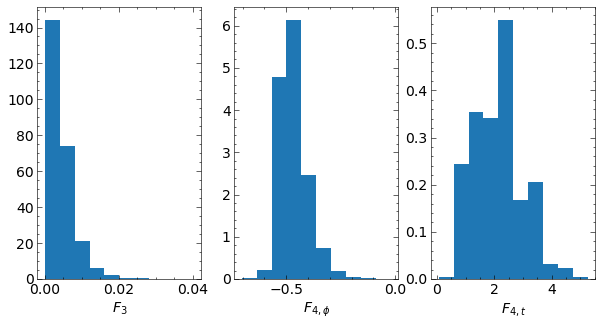

In [7]:
fig, [ax0, ax1, ax2] = plt.subplots(nrows=1, ncols=3, sharex=False,figsize=(10,5))  

ax0.hist(F3,density=True)
ax0.set_xlabel(r'$F_3$')
ax1.hist(F4p,density=True)
ax1.set_xlabel(r'$F_{4,\phi}$')
ax2.hist(F4t,density=True)
ax2.set_xlabel(r'$F_{4,t}$')